# Using Electronic Lab Notebook information for analysis

In this notebook we will demonstrate a simple use case of using queried NEXUS data to download files from XNAT.

XNAT Instance: https://xnat-curate.ae.mpg.de

XNAT Projects loaded: "NEXUS ECOG, NEXUS FMRI, NEXUS ECOG"

Steps:
1. Load data from xnat -> postgres -> nexus
2. Pick a simple query based on existing forms
3. Construct the query, and run it
4. Expose the result for further use.

# Some target queries

## Query 1
- "Gender" Male
- "Primary Language" Afrikaans
- "analysis_step" contains "synchrony"
- "Musical Training" yes
- "scan" FingerLoc

Query 1 output parameters required
- project, subject, session 

expected: nexus2, NB002, NB002_ECOG_1

## Query 2
- "manufacturer" EYELINK 
- "Psychiatric History" contains depression
- "Eye Dominance" Right

Query 2 output parameters required
- project, subject, session, scans

expected: nexus2, NB002, NB002_ET_1

## Query 3
- "Powerline Frequency" 50
- "Race" Asian
- "Eye Dominance" Right
- "Institute" University of Birmingham

Query 3 output parameters required
- project, subject, session

expected: nexus1, NA002, NA002_MEEG_1

## Query 4
- "Device Types" Type intercranial_sensor
- "Stimuli" VisualStims
- "Responses" contains ButtonPress

Query 4 output parameters required
- list of projects, subjects

expected: nexus1, nexus2, NA001, NA002, NB001, NB002

In [4]:
import os.path as op

import matplotlib.pyplot as plt

import xnat
import requests

import mne
from mne.viz import snapshot_brain_montage, plot_bridged_electrodes

import pydicom
from pprint import pprint

mne.set_log_level('ERROR')

In [5]:
# %matplotlib inline

In [6]:
# set the XNAT hostname
xnat_host = 'xnat-curate'

NEXUS Queries are shown in the other sample notebooks.

In [4]:
# Expected results of Query 3 - nexus1, NA002, NA002_MEEG_1

project_name = "nexus1"
subject_name = "NA002"
session_name = "NA002_MEEG_1"
scan_name = "RestingEO"
download_dir = "/Users/praveen.sripad/Downloads/2023-08-10_eln_demo"
downloaded_file = op.join(download_dir, 
                          "NA002_MEEG_1/scans/RestingEO-RestingEO/resources/FIF/files/NA002_MEEG_V1_RestingEO.fif")


In [5]:
if not op.isfile(downloaded_file):
    # start connection to XNAT
    with xnat.connect('https://%s.ae.mpg.de' % xnat_host,
                      netrc_file=op.join(op.expanduser('~'), '.%s_netrc' %
                      xnat_host.replace('-', '_')), loglevel='ERROR') as connection:
        # download the data
        connection.projects[project_name].subjects[subject_name].experiments[session_name].scans[scan_name].download_dir(download_dir)

assert op.isfile(downloaded_file), 'File not available.'

# Load and use the downloaded data

In [6]:
raw = mne.io.Raw(downloaded_file, preload=True)

In [7]:
raw.plot();

In [8]:
raw.compute_psd(fmin=0., fmax=200., picks=['mag']).plot(show=False);

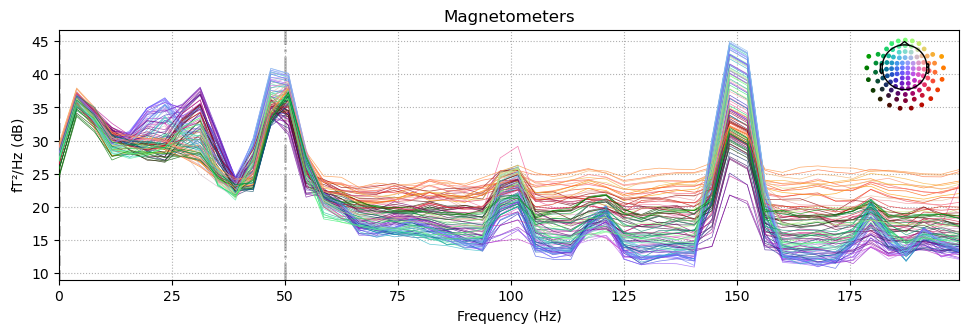

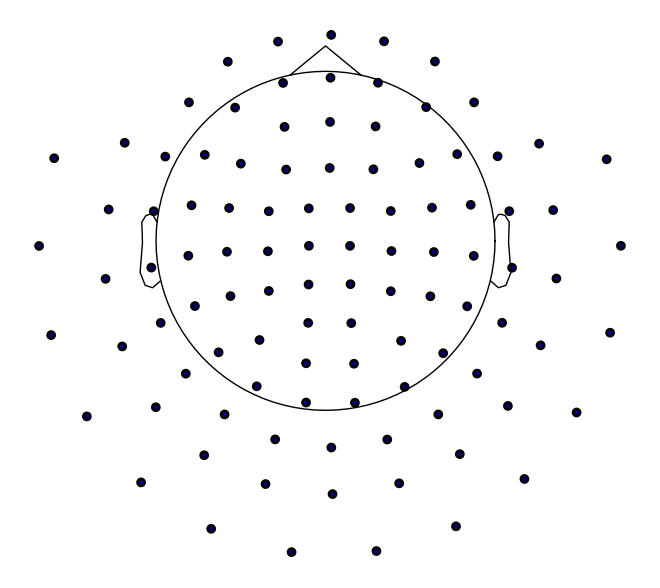

In [9]:
raw.plot_sensors(kind='topomap', ch_type='mag');

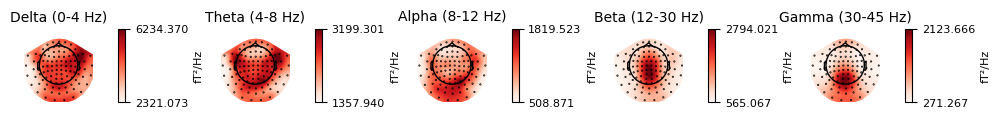

In [10]:
raw.plot_psd_topomap();

do further analysis... 

## Put back analysis terms into a custom form

In [11]:
headers = {'content-type': 'application/json', 'accept': 'application/json'}

uri = '/xapi/custom-fields/projects/%s/subjects/%s/experiments/%s/fields'\
        % (project_name, subject_name, session_name)

data={'6c6903c7-5c0a-4042-b6c6-a40c616fdd41':
        {'analysis_steps': 'load_data, filtering, time_frequency_analysis',
         'analysis_order': 'load_data, filtering, time_frequency_analysis'}}


In [12]:
# start connection to XNAT
with xnat.connect('https://%s.ae.mpg.de' % xnat_host,
                  netrc_file=op.join(op.expanduser('~'), '.%s_netrc' %
                  xnat_host.replace('-', '_')), loglevel='ERROR') as connection:    
    # upload the new data onto the analysis form
    status = connection.put(uri, json=data, headers=headers)
    # get the updated data and show it
    pprint(connection.get_json(uri))
    print('Status code:', status)

{'6c6903c7-5c0a-4042-b6c6-a40c616fdd41': {'analysis_order': 'load_data, '
                                                            'filtering, '
                                                            'time_frequency_analysis',
                                          'analysis_steps': 'load_data, '
                                                            'filtering, '
                                                            'time_frequency_analysis'},
 '7c185942-0d1b-4a29-8b12-f2b9d4f7707e': {'hasTheMeegDataBeenPreparedForUpload': 'yes',
                                          'numberOfScans': 1}}
Status code: <Response [200]>


## ECOG Data

Let us use the expected results from Query 1
- nexus2, NB002, NB002_ECOG_1


In [13]:
project_name = "nexus2"
subject_name = "NB002"
session_name = "NB002_ECOG_1"
scan_name = "DurR1"
download_dir = "/Users/praveen.sripad/Downloads/2023-08-10_eln_demo"
downloaded_file = op.join(download_dir, 
                          "NB002_ECOG_1/scans/DurR1-DurR1/resources/EDF/files/NB002_ECoG_V1_DurR1.EDF")

In [14]:
if not op.isfile(downloaded_file):
    # start connection to XNAT
    with xnat.connect('https://%s.ae.mpg.de' % xnat_host,
                      netrc_file=op.join(op.expanduser('~'), '.%s_netrc' %
                      xnat_host.replace('-', '_')), loglevel='ERROR') as connection:
        # download the data
        connection.projects[project_name].subjects[subject_name].experiments[session_name].scans[scan_name].download_dir(download_dir)

assert op.isfile(downloaded_file), 'File not available.'

In [15]:
# load the data
raw = mne.io.read_raw_edf(downloaded_file)

In [16]:
# plot the psds
raw.plot_psd(show=True);

/Users/praveen.sripad/miniconda3/envs/mne/lib/python3.10/site-packages/mne/viz/utils.py:137: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


In [17]:
# do some filtering
raw.load_data().filter(45., 145.).plot_psd(show=True);

/Users/praveen.sripad/miniconda3/envs/mne/lib/python3.10/site-packages/mne/viz/utils.py:137: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


## FMRI Data
- nexus3, NC001, NC001_MR_1

In [7]:
project_name = "nexus3"
subject_name = "NC001"
session_name = "NC001_MR_1"
scan_name = "29"
download_dir = "/Users/praveen.sripad/Downloads/2023-08-10_eln_demo"
downloaded_file = op.join(download_dir, 
                          "NC001_MR_1/scans/29-SC106_MR_V1_anat/resources/DICOM/files/2.25.53803668615885593554381663807106855176-29-127-1wunb9u.dcm")


In [8]:
if not op.isfile(downloaded_file):
    # start connection to XNAT
    with xnat.connect('https://%s.ae.mpg.de' % xnat_host,
                      netrc_file=op.join(op.expanduser('~'), '.%s_netrc' %
                      xnat_host.replace('-', '_')), loglevel='ERROR') as connection:
        # download the data
        connection.projects[project_name].subjects[subject_name].experiments[session_name].scans[scan_name].download_dir(download_dir)
    
assert op.isfile(downloaded_file), 'File not available.'

## Use pydicom to read the DICOM images and plot a slice

In [9]:
filename = downloaded_file
dataset = pydicom.dcmread(downloaded_file)


Filename.........: /Users/praveen.sripad/Downloads/2023-08-10_eln_demo/NC001_MR_1/scans/29-SC106_MR_V1_anat/resources/DICOM/files/2.25.53803668615885593554381663807106855176-29-127-1wunb9u.dcm
Storage type.....: 1.2.840.10008.5.1.4.1.1.4

Patient's name...: NC001, 
Patient id.......: NC001_MR_1
Modality.........: MR
Study Date.......: 20201120
Image size.......: 256 x 256, 131072 bytes
Pixel spacing....: [1, 1]
Slice location...: 29.572877725591


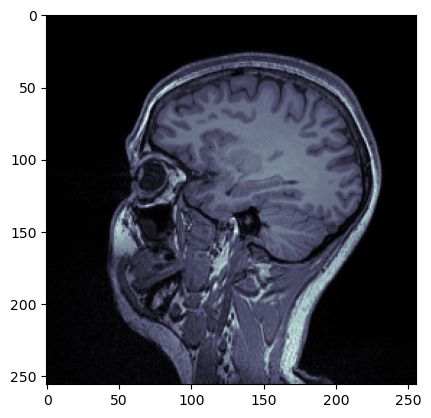

In [10]:
# Normal mode:
print()
print("Filename.........:", filename)
print("Storage type.....:", dataset.SOPClassUID)
print()

pat_name = dataset.PatientName
display_name = pat_name.family_name + ", " + pat_name.given_name
print("Patient's name...:", display_name)
print("Patient id.......:", dataset.PatientID)
print("Modality.........:", dataset.Modality)
print("Study Date.......:", dataset.StudyDate)

if 'PixelData' in dataset:
    rows = int(dataset.Rows)
    cols = int(dataset.Columns)
    print("Image size.......: {rows:d} x {cols:d}, {size:d} bytes".format(
        rows=rows, cols=cols, size=len(dataset.PixelData)))
    if 'PixelSpacing' in dataset:
        print("Pixel spacing....:", dataset.PixelSpacing)

# use .get() if not sure the item exists, and want a default value if missing
print("Slice location...:", dataset.get('SliceLocation', "(missing)"))

# plot the image using matplotlib
plt.imshow(dataset.pixel_array, cmap=plt.cm.bone)
plt.show()

END.